In [1]:
import torch.nn as nn
import torch
import math
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
import numpy as np
import tqdm
from torch.utils.data import Dataset
import random
from collections import Counter
import re
import os
from IPython.display import clear_output, display
from collections import defaultdict
import time
import matplotlib.pyplot as plt

In [ ]:
class args(object):
    
    dataset_path = './Data'
    vocab_size = None
    corpus_lines = None
    on_memory = True
    min_freq = 1
    seq_len = 20
    batch_size = 5
    num_workers = 0
    train_dataset = os.path.join(dataset_path, 'wiki.train.txt')
    val_dataset = os.path.join(dataset_path, 'wiki.valid.txt')
    test_dataset = os.path.join(dataset_path, 'wiki.test.txt')
    hidden = 32
    layers = 2
    attn_heads = 4
    lr = 1e-3
    adam_beta1 = 0.9
    adam_beta2 = 0.999
    adam_weight_decay = 0.01
    with_cuda = True
    cuda_devices = None
    log_freq = 10
    epochs = 3
    val_steps = 5
    model_save_freq = 1
    model_name = 'BERT' 
    model_path ='./'+ model_name +'/Model/'
    log_path = './' + model_name + '/Log/'
    
    
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

if not os.path.exists(args.log_path):
    os.makedirs(args.log_path)
    
with open(args.train_dataset, "r",) as f:
        vocab = WordVocab(f, max_size=args.vocab_size, min_freq=args.min_freq)

In [ ]:
class TorchVocab(object):
    """Defines a vocabulary object that will be used to numericalize a field.
    Attributes:
        freqs: A collections.Counter object holding the frequencies of tokens
            in the data used to build the Vocab.
        stoi: A collections.defaultdict instance mapping token strings to
            numerical identifiers.
        itos: A list of token strings indexed by their numerical identifiers.
    """

    def __init__(self, counter, max_size=None, min_freq=1, specials=['<pad>', '<oov>'],
                 vectors=None, unk_init=None, vectors_cache=None):
        """Create a Vocab object from a collections.Counter.
        Arguments:
            counter: collections.Counter object holding the frequencies of
                each value found in the data.
            max_size: The maximum size of the vocabulary, or None for no
                maximum. Default: None.
            min_freq: The minimum frequency needed to include a token in the
                vocabulary. Values less than 1 will be set to 1. Default: 1.
            specials: The list of special tokens (e.g., padding or eos) that
                will be prepended to the vocabulary in addition to an <unk>
                token. Default: ['<pad>']
            vectors: One of either the available pretrained vectors
                or custom pretrained vectors (see Vocab.load_vectors);
                or a list of aforementioned vectors
            unk_init (callback): by default, initialize out-of-vocabulary word vectors
                to zero vectors; can be any function that takes in a Tensor and
                returns a Tensor of the same size. Default: torch.Tensor.zero_
            vectors_cache: directory for cached vectors. Default: '.vector_cache'
        """
        self.freqs = counter # for checking the frequency
        counter = counter.copy()
        min_freq = max(min_freq, 1)

        self.itos = list(specials)
        # frequencies of special tokens are not counted when building vocabulary
        # in frequency order
        for tok in specials:
            del counter[tok]

        max_size = None if max_size is None else max_size + len(self.itos) # extend the max_size

        # sort by frequency, then alphabetically
        words_and_frequencies = sorted(counter.items(), key=lambda tup: tup[0])
        words_and_frequencies.sort(key=lambda tup: tup[1], reverse=True)

        for word, freq in words_and_frequencies:
            if freq < min_freq or len(self.itos) == max_size:
                break
            self.itos.append(word) # all filtered words

        # stoi is simply a reverse dict for itos
        self.stoi = {tok: i for i, tok in enumerate(self.itos)}

        self.vectors = None
        if vectors is not None:
            self.load_vectors(vectors, unk_init=unk_init, cache=vectors_cache)
        else:
            assert unk_init is None and vectors_cache is None

    def __eq__(self, other):
        if self.freqs != other.freqs:
            return False
        if self.stoi != other.stoi:
            return False
        if self.itos != other.itos:
            return False
        if self.vectors != other.vectors:
            return False
        return True

    def __len__(self):
        return len(self.itos)

    def vocab_rerank(self):
        self.stoi = {word: i for i, word in enumerate(self.itos)}

    def extend(self, v, sort=False):
        words = sorted(v.itos) if sort else v.itos
        for w in words:
            if w not in self.stoi:
                self.itos.append(w)
                self.stoi[w] = len(self.itos) - 1


class Vocab(TorchVocab):
    def __init__(self, counter, max_size=None, min_freq=1):
        self.pad_index = 0
        self.unk_index = 1
        self.eos_index = 2
        self.sos_index = 3
        self.mask_index = 4
        super().__init__(counter, specials=["<pad>", "<unk>", "<eos>", "<sos>", "<mask>"],
                         max_size=max_size, min_freq=min_freq)

    def to_seq(self, sentece, seq_len, with_eos=False, with_sos=False) -> list:
        pass

    def from_seq(self, seq, join=False, with_pad=False):
        pass

    @staticmethod
    def load_vocab(vocab_path: str) -> 'Vocab':
        with open(vocab_path, "rb") as f:
            return pickle.load(f)

    def save_vocab(self, vocab_path):
        with open(vocab_path, "wb") as f:
            pickle.dump(self, f)


# Building Vocab with text files
class WordVocab(Vocab):
    def __init__(self, texts, max_size=None, min_freq=1):
        print("Building Vocab")
        counter = Counter()
        for line in tqdm.tqdm(texts):
            if isinstance(line, list):
                words = line
            else:
                words = line.replace("\n", "").replace("\t", "").split()

            for word in words:
                counter[word] += 1
        super().__init__(counter, max_size=max_size, min_freq=min_freq)

    def to_seq(self, sentence, seq_len=None, with_eos=False, with_sos=False, with_len=False):
        if isinstance(sentence, str):
            sentence = sentence.split()

        seq = [self.stoi.get(word, self.unk_index) for word in sentence]

        if with_eos:
            seq += [self.eos_index]  # this would be index 1
        if with_sos:
            seq = [self.sos_index] + seq

        origin_seq_len = len(seq)

        if seq_len is None:
            pass
        elif len(seq) <= seq_len:
            seq += [self.pad_index for _ in range(seq_len - len(seq))]
        else:
            seq = seq[:seq_len]

        return (seq, origin_seq_len) if with_len else seq

    def from_seq(self, seq, join=False, with_pad=False):
        words = [self.itos[idx]
                 if idx < len(self.itos)
                 else "<%d>" % idx
                 for idx in seq
                 if not with_pad or idx != self.pad_index]

        return " ".join(words) if join else words

    @staticmethod
    def load_vocab(vocab_path: str) -> 'WordVocab':
        with open(vocab_path, "rb") as f:
            return pickle.load(f)
        
        
class BERTDataset(Dataset):
    def __init__(self, corpus_path, vocab, seq_len, encoding="utf-8", corpus_lines=None, on_memory=True):
        self.vocab = vocab
        self.seq_len = seq_len

        self.on_memory = on_memory
        self.corpus_lines = corpus_lines
        self.corpus_path = corpus_path
        self.encoding = encoding

        with open(corpus_path, "r", encoding=encoding) as f:
            if self.corpus_lines is None and not on_memory:
                for _ in tqdm.tqdm(f, desc="Loading Dataset", total=corpus_lines):
                    self.corpus_lines += 1
            
            if on_memory:
#                 self.lines = [line[:-1].replace(",","\t").split("\t")
#                               for line in tqdm.tqdm(f, desc="Loading Dataset", total=corpus_lines)]
                self.lines = [re.split(r'[;|,|.|\t|\n]',line[:-1])
                              for line in tqdm.tqdm(f, desc="Loading Dataset", total=corpus_lines)]
    
                new_lines = []
        
                for l in self.lines:
                    new_l = []
                    for seg in l:
                        if not ("=" in seg or seg is " "):
                            new_l.append(seg)
                    if len(new_l) > 1:
                        new_lines.append(new_l)

                self.lines = new_lines

                del new_lines
    
                self.corpus_lines = len(self.lines)
            
        if not on_memory:
            self.file = open(corpus_path, "r", encoding=encoding)
            self.random_file = open(corpus_path, "r", encoding=encoding)

            for _ in range(random.randint(self.corpus_lines if self.corpus_lines < 1000 else 1000)):
                self.random_file.__next__()

    def __len__(self):
        return self.corpus_lines

    def __getitem__(self, item):
        t1, t2, is_next_label = self.random_sent(item)
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)

        # [CLS] tag = SOS tag, [SEP] tag = EOS tag
        t1 = [self.vocab.sos_index] + t1_random + [self.vocab.eos_index]
        t2 = t2_random + [self.vocab.eos_index]

        t1_label = [self.vocab.pad_index] + t1_label + [self.vocab.pad_index]
        t2_label = t2_label + [self.vocab.pad_index]

        segment_label = ([1 for _ in range(len(t1))] + [2 for _ in range(len(t2))])[:self.seq_len]
        bert_input = (t1 + t2)[:self.seq_len]
        bert_label = (t1_label + t2_label)[:self.seq_len]

        padding = [self.vocab.pad_index for _ in range(self.seq_len - len(bert_input))]
        bert_input.extend(padding), bert_label.extend(padding), segment_label.extend(padding)

        output = {"bert_input": bert_input,
                  "bert_label": bert_label,
                  "segment_label": segment_label,
                  "is_next": is_next_label}

        return {key: torch.tensor(value) for key, value in output.items()}

    def random_word(self, sentence):
        tokens = sentence.split() #still string
        output_label = []

        for i, token in enumerate(tokens):
            prob = random.random()
            if prob < 0.15:
                prob /= 0.15

                # 80% randomly change token to mask token
                if prob < 0.8:
                    tokens[i] = self.vocab.mask_index

                # 10% randomly change token to random token
                elif prob < 0.9:
                    tokens[i] = random.randrange(len(self.vocab))

                # 10% randomly change token to current token
                else:
                    tokens[i] = self.vocab.stoi.get(token, self.vocab.unk_index) # change to idx

                output_label.append(self.vocab.stoi.get(token, self.vocab.unk_index))

            else:
                tokens[i] = self.vocab.stoi.get(token, self.vocab.unk_index)
                output_label.append(0)

        return tokens, output_label

    def random_sent(self, index):
        t1, t2 = self.get_corpus_line(index)

        # output_text, label(isNotNext:0, isNext:1)
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0

    def get_corpus_line(self, item):
        if self.on_memory:
            idx = np.random.randint(len(self.lines[item])-1)
            return self.lines[item][idx], self.lines[item][idx+1]
        else:
            line = self.file.__next__()
            if line is None:
                self.file.close()
                self.file = open(self.corpus_path, "r", encoding=self.encoding)
                line = self.file.__next__()

            t1, t2 = line[:-1].split("\t")
            return t1, t2

    def get_random_line(self):
        
        if self.on_memory:
            return self.lines[random.randrange(len(self.lines))][1]

        line = self.file.__next__()
        if line is None:
            self.file.close()
            self.file = open(self.corpus_path, "r", encoding=self.encoding)
            for _ in range(random.randint(self.corpus_lines if self.corpus_lines < 1000 else 1000)):
                self.random_file.__next__()
            line = self.random_file.__next__()
        return line[:-1].split("\t")[1]


class GELU(nn.Module):
    """
    Paper Section 3.4, last paragraph notice that BERT used the GELU instead of RELU
    """

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
    
    
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))
    
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))

class PositionalEmbedding(nn.Module):

    def __init__(self, d_model, max_len=512):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)] # extract certain length for embedding the position
    
class TokenEmbedding(nn.Embedding):
    def __init__(self, vocab_size, embed_size=512):
        super().__init__(vocab_size, embed_size, padding_idx=0)
                         
class SegmentEmbedding(nn.Embedding): # What's the input of SegmentEmbedding
    def __init__(self, embed_size=512):
        super().__init__(3, embed_size, padding_idx=0) # why 3?

class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """

    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)  # B, h, L, d_k
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)

class BERTEmbedding(nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)
        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, embed_size, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """
        super().__init__()
        self.token = TokenEmbedding(vocab_size=vocab_size, embed_size=embed_size)
        self.position = PositionalEmbedding(d_model=self.token.embedding_dim)
        self.segment = SegmentEmbedding(embed_size=self.token.embedding_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_size = embed_size

    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)

class TransformerBlock(nn.Module):
    """
    Bidirectional Encoder = Transformer (self-attention)
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        """
        :param hidden: hidden size of transformer
        :param attn_heads: head sizes of multi-head attention
        :param feed_forward_hidden: feed_forward_hidden, usually 4*hidden_size
        :param dropout: dropout rate
        """

        super().__init__()
        self.attention = MultiHeadedAttention(h=attn_heads, d_model=hidden)
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden, dropout=dropout)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask)) # will be fed in a Linear before attention
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)

class BERT(nn.Module):
    """
    BERT model : Bidirectional Encoder Representations from Transformers.
    """

    def __init__(self, vocab_size, hidden=768, n_layers=12, attn_heads=12, dropout=0.1):
        """
        :param vocab_size: vocab_size of total words
        :param hidden: BERT model hidden size
        :param n_layers: numbers of Transformer blocks(layers)
        :param attn_heads: number of attention heads
        :param dropout: dropout rate
        """

        super().__init__()
        self.hidden = hidden
        self.n_layers = n_layers
        self.attn_heads = attn_heads

        # paper noted they used 4*hidden_size for ff_network_hidden_size
        self.feed_forward_hidden = hidden * 4

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=hidden)

        # multi-layers transformer blocks, deep network
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden, attn_heads, self.feed_forward_hidden, dropout) for _ in range(n_layers)])

    def forward(self, x, segment_info):
        # attention masking for padded token
        # torch.ByteTensor([batch_size, 1, seq_len, seq_len)
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x, segment_info)

        # running over multiple transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)

        return x


class BERTLM(nn.Module):
    """
    BERT Language Model
    Next Sentence Prediction Model + Masked Language Model
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """

        super().__init__()
        self.bert = bert
        self.next_sentence = NextSentencePrediction(self.bert.hidden)
        self.mask_lm = MaskedLanguageModel(self.bert.hidden, vocab_size)

    def forward(self, x, segment_label):
        x = self.bert(x, segment_label)
        return self.next_sentence(x), self.mask_lm(x)


class NextSentencePrediction(nn.Module):
    """
    2-class classification model : is_next, is_not_next
    """

    def __init__(self, hidden):
        """
        :param hidden: BERT model output size
        """
        super().__init__()
        self.linear = nn.Linear(hidden, 2)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x[:, 0])) # only take the first one to predict


class MaskedLanguageModel(nn.Module):
    """
    predicting origin token from masked input sequence
    n-class classification problem, n-class = vocab_size
    """

    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = nn.Linear(hidden, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x)) # predict the whole sentence

class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5) # 0.02

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

class BERTTrainer:
    """
    BERTTrainer make the pretrained BERT model with two LM training method.
        1. Masked Language Model : 3.3.1 Task #1: Masked LM
        2. Next Sentence prediction : 3.3.2 Task #2: Next Sentence Prediction
    please check the details on README.md with simple example.
    """

    def __init__(self, bert: BERT, vocab_size: int,
                 train_dataloader: DataLoader, val_data_loader: DataLoader = None, test_dataloader: DataLoader = None,
                 lr: float = 1e-4, betas=(0.9, 0.999), weight_decay: float = 0.01, warmup_steps=10000,
                 with_cuda: bool = True, cuda_devices=None, log_freq: int = 10):
        """
        :param bert: BERT model which you want to train
        :param vocab_size: total word vocab size
        :param train_dataloader: train dataset data loader
        :param test_dataloader: test dataset data loader [can be None]
        :param lr: learning rate of optimizer
        :param betas: Adam optimizer betas
        :param weight_decay: Adam optimizer weight decay param
        :param with_cuda: traning with cuda
        :param log_freq: logging frequency of the batch iteration
        """

        # Setup cuda device for BERT training, argument -c, --cuda should be true
        cuda_condition = torch.cuda.is_available() and with_cuda
        self.device = torch.device("cuda:0" if cuda_condition else "cpu")

        # This BERT model will be saved every epoch
        self.bert = bert
        # Initialize the BERT Language Model, with BERT model
        self.model = BERTLM(bert, vocab_size).to(self.device)

        # Distributed GPU training if CUDA can detect more than 1 GPU
        if with_cuda and torch.cuda.device_count() > 1:
            print("Using %d GPUS for BERT" % torch.cuda.device_count())
            self.model = nn.DataParallel(self.model, device_ids=cuda_devices)

        # Setting the train and test data loader
        self.train_data = train_dataloader
        self.val_data = val_data_loader
        self.test_data = test_dataloader

        # Setting the Adam optimizer with hyper-param
        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.optim_schedule = ScheduledOptim(self.optim, self.bert.hidden, n_warmup_steps=warmup_steps)

        # Using Negative Log Likelihood Loss function for predicting the masked_token
        self.criterion = nn.NLLLoss(ignore_index=0)

        self.log_freq = log_freq
        
        self.train_hist = defaultdict(list)

        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))
        
        

    def train(self, epoch):

        self.iteration(epoch, self.train_data, mode = 'Train')

    def test(self, epoch):
        
        self.iteration(epoch, self.test_data, mode = 'Test')
        
    def valid(self, epoch):
        
        self.iteration(epoch, self.val_data, mode = 'Val')

    def iteration(self, epoch, data_loader, mode = None):
        """
        loop over the data_loader for training or testing
        if on train status, backward operation is activated
        and also auto save the model every peoch
        :param epoch: current epoch index
        :param data_loader: torch.utils.data.DataLoader for iteration
        :param train: boolean value of is train or test
        :return: None
        """
        str_code = mode
        
        if mode == 'Train':
            self.model.train()
        else:
            self.model.eval()

        # Setting the tqdm progress bar
        data_iter = enumerate(data_loader)

        total_loss = 0.0
        total_correct = 0
        total_element = 0

        for i, data in data_iter:
            
            start_t = time.time()
            
            # 0. batch_data will be sent into the device(GPU or cpu)
            data = {key: value.to(self.device) for key, value in data.items()}

            # 1. forward the next_sentence_prediction and masked_lm model
            next_sent_output, mask_lm_output = self.model.forward(data["bert_input"], data["segment_label"])

            # 2-1. NLL(negative log likelihood) loss of is_next classification result
            next_loss = self.criterion(next_sent_output, data["is_next"])

            # 2-2. NLLLoss of predicting masked token word
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])

            # 2-3. Adding next_loss and mask_loss : 3.4 Pre-training Procedure
            loss = next_loss + mask_loss

            # 3. backward and optimization only in train
            
            end_t = time.time()
            
            # next sentence prediction accuracy
            correct = next_sent_output.argmax(dim=-1).eq(data["is_next"]).sum().item()
            total_loss += loss.item()
            total_correct += correct
            total_element += data["is_next"].nelement()
            
            if mode == 'Train':
                self.optim_schedule.zero_grad()
                loss.backward()
                self.optim_schedule.step_and_update_lr()
                
            elif mode == 'Val':
                if i >= args.val_steps:
                    break
                
            if i % self.log_freq == 0:
                 print(' {:s} | Epoch {:d} | Step {:.2f}% | lr {:.6f} | Loss: {:.4f} | Acc: {:.4f}% | Time: {:.1f}s' .format\
                (mode , epoch,(i+1)*100/len(data_loader), self.optim_schedule._optimizer.param_groups[0]['lr'],
                 loss.item() , correct / data["is_next"].nelement() * 100 ,
                 end_t - start_t))
                       
        if mode == 'Train':
#             clear_output()
            self.train_hist['Loss'].append(total_loss / (i + 1))
            self.train_hist['Acc'].append(total_correct / total_element * 100)
            self.valid(epoch)
            self.plot_train_hist('Training')
            if epoch % args.model_save_freq == 0 and epoch != 0:
                self.model_save('Training')
                       
        elif mode == 'Val':
            self.train_hist['V_Loss'].append(total_loss / (i + 1))
            self.train_hist['V_Acc'].append(total_correct / total_element * 100)
                       
        elif mode == 'Test':  
            print('Fuck in the test')
            
            raise StopIteration
            
            self.train_hist['T_Loss'].append(total_loss / (i + 1))
            self.train_hist['T_Acc'].append(total_correct / total_element * 100)
                       
        else: 
            raise NotImplementedError
    
    
    def model_save(self,step):
        
        path = args.model_path + args.model_name+'_Step_' + str(step) + '.pth'
        torch.save({args.model_name:self.model.state_dict()}, path)
        print('Model Saved')
        
    def load_step_dict(self, step):
        
        path = args.model_path + args.model_name +'_Step_' + str(step) + '.pth'
        self.model.load_state_dict(torch.load(path, map_location = lambda storage, loc: storage)[args.model_name])
        print('Model Loaded')
                       
                       
    def plot_train_hist(self, step = None):
        fig = plt.figure(figsize=(20, 10))
        for name in self.train_hist.keys():
            if 'Loss' in name:
                plt.subplot(211)
                plt.plot(self.train_hist[name],marker='o',label= name)
                plt.ylabel('Loss',fontsize=15)
                plt.xlabel('Number of epochs',fontsize=15)
                plt.title('Loss',fontsize=20,fontweight ="bold")
                plt.legend(loc='upper left')
            else:
                plt.subplot(212)
                plt.plot(self.train_hist[name],marker='o',label= name)
                plt.ylabel('Accuracy',fontsize=15)
                plt.xlabel('Number of epochs',fontsize=15)
                plt.title('Accuracy',fontsize=20,fontweight ="bold")
                plt.legend(loc='upper left')

        plt.tight_layout()
        plt.show()
        if step is not None:
            path = args.log_path + "Train_Hist"+str(step)+".png"
            fig.savefig(path)  


In [22]:
train_dataset = BERTDataset(args.train_dataset, vocab, seq_len=args.seq_len, corpus_lines=args.corpus_lines, on_memory=args.on_memory)
val_dataset = BERTDataset(args.val_dataset, vocab, seq_len=args.seq_len, corpus_lines=args.corpus_lines, on_memory=args.on_memory)
test_dataset = BERTDataset(args.test_dataset, vocab, seq_len=args.seq_len, on_memory=args.on_memory)

train_data_loader = DataLoader(train_dataset, batch_size=args.batch_size, num_workers=args.num_workers)
val_data_loader = DataLoader(val_dataset, batch_size=args.batch_size, num_workers=args.num_workers)
test_data_loader = DataLoader(test_dataset, batch_size=args.batch_size, num_workers=args.num_workers)

bert = BERT(len(vocab), hidden=args.hidden, n_layers=args.layers, attn_heads=args.attn_heads)

trainer = BERTTrainer(bert, len(vocab), train_dataloader=train_data_loader, val_data_loader = val_data_loader,test_dataloader=test_data_loader,
                          lr=args.lr, betas=(args.adam_beta1, args.adam_beta2), weight_decay=args.adam_weight_decay,
                          with_cuda=args.with_cuda, cuda_devices=args.cuda_devices, log_freq=args.log_freq)

print(train_dataset.lines)

Loading Dataset: 36718it [00:00, 142564.25it/s]
Loading Dataset: 3760it [00:00, 151832.93it/s]
Loading Dataset: 4358it [00:00, 166973.69it/s]


In [27]:
epoch = 0

 Train | Epoch 0 | Step 0.20% | lr 0.000000 | Loss: 12.2318 | Acc: 62.5000% | Time: 0.2s
 Train | Epoch 0 | Step 2.19% | lr 0.000002 | Loss: 12.1747 | Acc: 68.7500% | Time: 0.2s
 Train | Epoch 0 | Step 4.17% | lr 0.000004 | Loss: 12.2554 | Acc: 43.7500% | Time: 0.2s
 Train | Epoch 0 | Step 6.16% | lr 0.000005 | Loss: 12.2612 | Acc: 50.0000% | Time: 0.2s
 Train | Epoch 0 | Step 8.15% | lr 0.000007 | Loss: 12.2364 | Acc: 28.1250% | Time: 0.2s
 Train | Epoch 0 | Step 10.14% | lr 0.000009 | Loss: 12.4799 | Acc: 56.2500% | Time: 0.2s
 Train | Epoch 0 | Step 12.13% | lr 0.000011 | Loss: 12.1217 | Acc: 68.7500% | Time: 0.2s
 Train | Epoch 0 | Step 14.12% | lr 0.000013 | Loss: 12.0854 | Acc: 59.3750% | Time: 0.2s
 Train | Epoch 0 | Step 16.10% | lr 0.000014 | Loss: 11.9074 | Acc: 53.1250% | Time: 0.2s
 Train | Epoch 0 | Step 18.09% | lr 0.000016 | Loss: 12.6043 | Acc: 37.5000% | Time: 0.2s
 Train | Epoch 0 | Step 20.08% | lr 0.000018 | Loss: 12.1173 | Acc: 46.8750% | Time: 0.2s
 Train | Epoch 

/Users/richard/.virtualenvs/python3.6/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


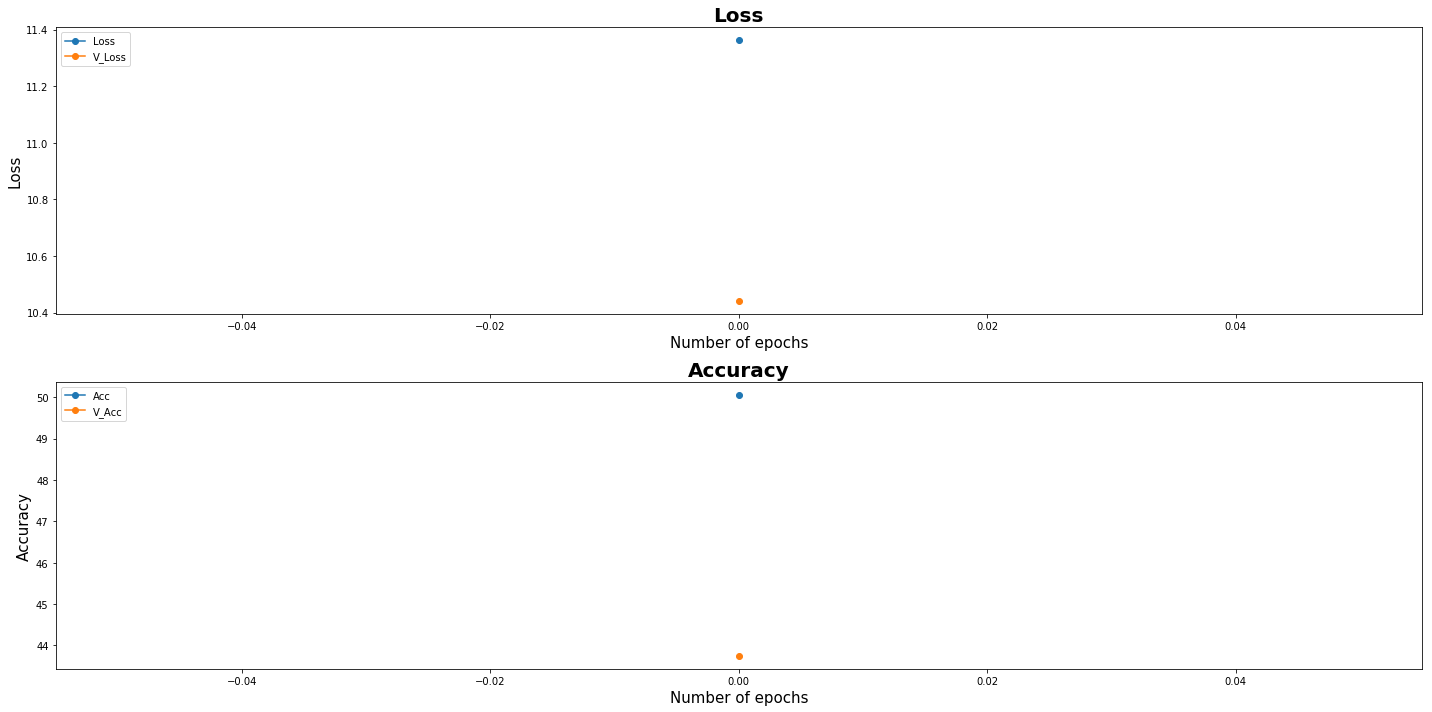

 Train | Epoch 1 | Step 0.20% | lr 0.000089 | Loss: 10.6300 | Acc: 62.5000% | Time: 0.2s
 Train | Epoch 1 | Step 2.19% | lr 0.000091 | Loss: 10.7307 | Acc: 50.0000% | Time: 0.2s
 Train | Epoch 1 | Step 4.17% | lr 0.000093 | Loss: 10.5396 | Acc: 46.8750% | Time: 0.2s
 Train | Epoch 1 | Step 6.16% | lr 0.000094 | Loss: 10.4286 | Acc: 62.5000% | Time: 0.2s
 Train | Epoch 1 | Step 8.15% | lr 0.000096 | Loss: 10.2378 | Acc: 37.5000% | Time: 0.2s
 Train | Epoch 1 | Step 10.14% | lr 0.000098 | Loss: 10.5532 | Acc: 59.3750% | Time: 0.2s
 Train | Epoch 1 | Step 12.13% | lr 0.000100 | Loss: 10.6232 | Acc: 56.2500% | Time: 0.2s
 Train | Epoch 1 | Step 14.12% | lr 0.000101 | Loss: 10.4170 | Acc: 46.8750% | Time: 0.2s
 Train | Epoch 1 | Step 16.10% | lr 0.000103 | Loss: 10.5811 | Acc: 50.0000% | Time: 0.2s
 Train | Epoch 1 | Step 18.09% | lr 0.000105 | Loss: 10.5106 | Acc: 53.1250% | Time: 0.2s
 Train | Epoch 1 | Step 20.08% | lr 0.000107 | Loss: 10.5575 | Acc: 62.5000% | Time: 0.2s
 Train | Epoch 

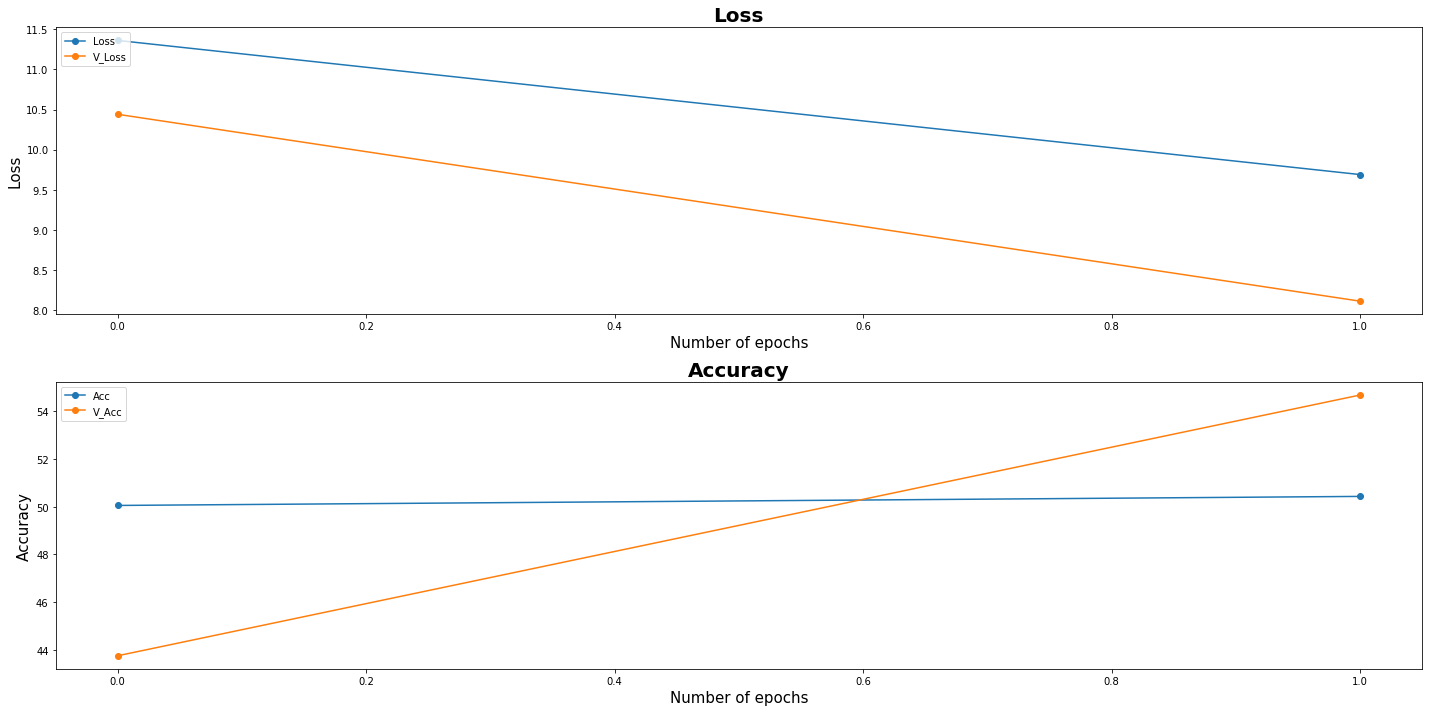

Model Saved
 Train | Epoch 2 | Step 0.20% | lr 0.000178 | Loss: 8.7679 | Acc: 40.6250% | Time: 0.2s
 Train | Epoch 2 | Step 2.19% | lr 0.000180 | Loss: 9.0176 | Acc: 53.1250% | Time: 0.2s
 Train | Epoch 2 | Step 4.17% | lr 0.000182 | Loss: 7.6078 | Acc: 62.5000% | Time: 0.2s
 Train | Epoch 2 | Step 6.16% | lr 0.000183 | Loss: 8.4787 | Acc: 31.2500% | Time: 0.2s
 Train | Epoch 2 | Step 8.15% | lr 0.000185 | Loss: 9.1814 | Acc: 46.8750% | Time: 0.2s
 Train | Epoch 2 | Step 10.14% | lr 0.000187 | Loss: 8.9384 | Acc: 56.2500% | Time: 0.2s
 Train | Epoch 2 | Step 12.13% | lr 0.000189 | Loss: 8.3662 | Acc: 50.0000% | Time: 0.2s
 Train | Epoch 2 | Step 14.12% | lr 0.000190 | Loss: 8.8428 | Acc: 62.5000% | Time: 0.2s
 Train | Epoch 2 | Step 16.10% | lr 0.000192 | Loss: 8.1893 | Acc: 56.2500% | Time: 0.2s
 Train | Epoch 2 | Step 18.09% | lr 0.000194 | Loss: 8.3351 | Acc: 31.2500% | Time: 0.2s
 Train | Epoch 2 | Step 20.08% | lr 0.000196 | Loss: 7.6074 | Acc: 53.1250% | Time: 0.2s
 Train | Epoch

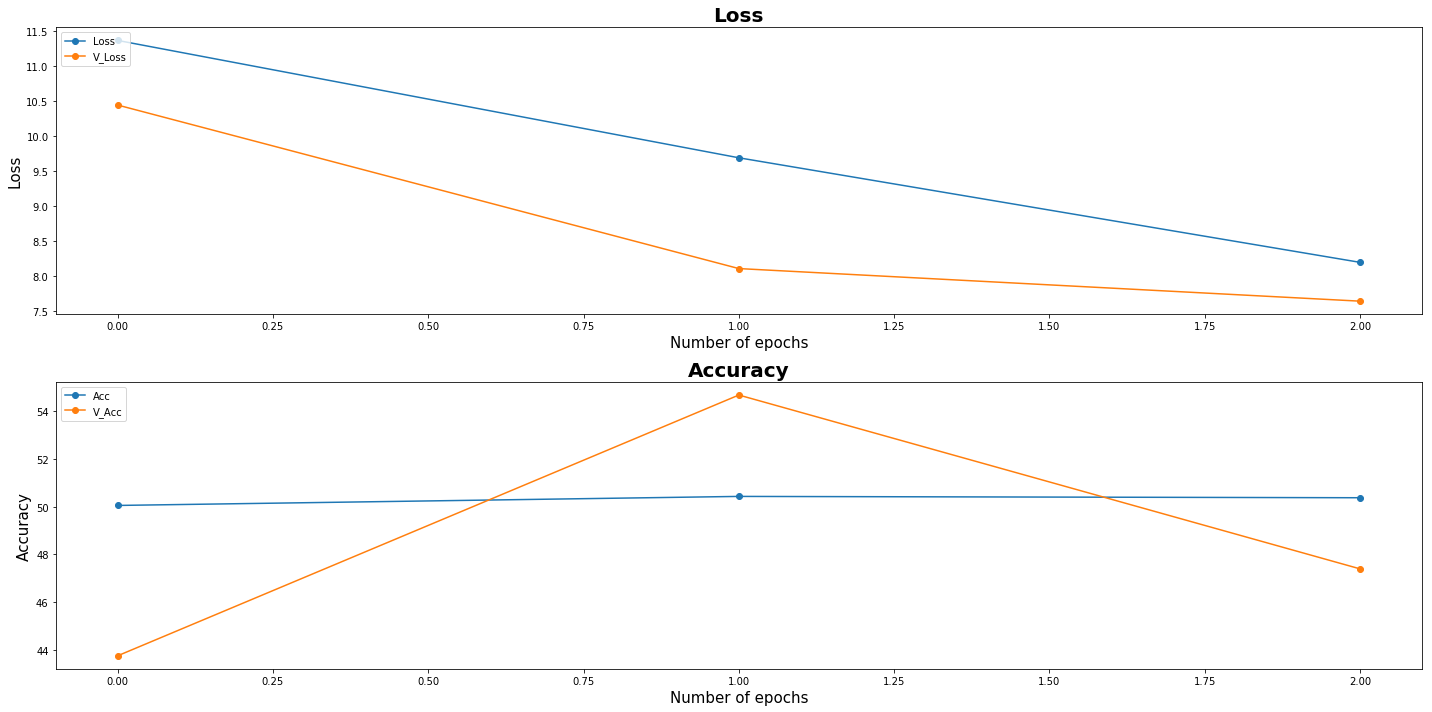

Model Saved


In [28]:
while epoch < args.epochs:
    trainer.train(epoch)
    epoch += 1